In [1]:
import json
import google.generativeai as genai
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
# Set the API key directly
from google.colab import userdata
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

In [3]:
# Function to Prepare Image For Google Gemini
def prepare_image_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    with open(file_path, "rb") as file:
        bytes_data = file.read()

    image_data = [
        {
            "mime_type": "image/jpeg",
            "data": bytes_data
        }
    ]
    return image_data


In [4]:
# Function for Initialization of Google Gemini
def extract_invoice_fields(image_data):
    input_prompt ="""
               You are an expert in understanding and extracting detailed information from invoices of any kind.
               You will receive various invoice images as input and need to provide accurate and comprehensive answers based on the extracted details.
               The extracted information should cover a wide range of invoices, including food invoices, e-commerce invoices, utility bills, and any other type of invoice.
               Below is an example structure, but please adapt and modify the structure as needed for different invoice types:
               {
                   "Supplier": {
                       "Name": "Supplier Name",
                       "Address": "123 Supplier St, City, ZIP",
                       "PAN Number": "PAN123456789",
                       "GST Number": "GST0000",
                       "Contact": "xxxxxxxxxxx"
                   },
                   "ReceiptDetails": {
                       "Billing Address": "Customer Billing Address",
                       "Shipping Address": "Customer Shipping Address",
                       "Invoice Number": "INV123456",
                       "Date": "YYYY-MM-DD",
                       "Time": "HH:MM:SS",
                   },
                   "Items": [
                       {
                           "ItemName": "Product Name or Service",
                           "Quantity": 2,
                           "Unit Price": "50.00",
                           "Total Price": "100.00"
                       },
                       {
                           "ItemName": "Another Product",
                           "Quantity": 3,
                           "Unit Price": "30.00",
                           "Total Price": "90.00"
                       }
                   ],

                   "Payment Details" :{
                       "Payment Method": "Credit Card / Cash / Bank Transfer / Other",
                       "Currency": "USD",
                       "Total Amount": "250.00",
                       "Taxes": "25.00",
                       "Discounts": "5.00"
                   }
                   "Tax calculation" :{
                    ......
                   }
               }

               Instructions for Processing Invoices:

               1. Tax Calculations:
                   Sum all taxes (e.g., CGST, SGST, and any others) and ensure the total tax amount is accurate.
                   If tax percentages are listed, verify they sum up correctly to the total tax amount.
                   Ensure that the taxable amount plus total taxes equals the final amount after applying any discounts.

               2. Item Extraction:
                   Split item details correctly even if item names or descriptions span multiple rows.
                   Treat every line within the same column as part of a single item.
                   If quantity is more than one then unit price and total price can not be same
                   If unit price is not given of an item then divide amount by quantity to get Unit price

               3. Invoice Generation Time:
                   Look for common formats such as "am/PM" to identify when the invoice was generated or paid.

               4. Data Verification:
                   Cross-verify extracted data to ensure it matches the expected invoice totals:
                     Verify if the total amount equals the sum of item prices plus taxes, minus any discounts.
                     Check if the total quantity of items matches the sum of quantities for each item if provided.

               5. Subtotal Calculation:
                   Ignore extracting 'Subtotal' directly from the image.
                   The actual 'Subtotal' should be calculated as:
                    Subtotal = TotalAmount - TaxAmount + DiscountAmount`
                   Ensure the validation that:
                    FinalTotal = Subtotal + TaxAmount - DiscountAmount`

               6. Currency Extraction:
                  Don't just use the currency sumbol in json as it is. Find out the name of that currency adn then add that name in currency.

               """

    model = genai.GenerativeModel('gemini-1.5-flash')

    response = model.generate_content([input_prompt, image_data[0]])
    return response.text

In [5]:
# Function to Save data to Json
def save_to_json(data, output_path):
    with open(output_path, "w") as json_file:
        json.dump(data, json_file, indent=4)


In [6]:
# Main Function
def main():

    # Input and Output File Paths
    #input_file_path = "/content/drive/MyDrive/Task3/invoices/invoice_pages-to-jpg-0001.jpg"
    input_file_path = "/content/drive/MyDrive/Task3/invoices/our-food-bill-gives-an.jpg"
    #input_file_path = "/content/drive/MyDrive/Task3/invoices/transe99_page-0001.jpg"
    output_file_path = "/content/drive/MyDrive/Colab Notebooks/task9.json"

    # Read and Print the Image
    img = cv2.imread(input_file_path)
    print("Input Invoice Image")
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    try:
        # Prepare image data
        image_data = prepare_image_data(input_file_path)

        # Extract fields from invoice using Gemini
        response_text = extract_invoice_fields(image_data)

        # Cleaning the initial_response to remove delimiters and language specifier
        json_content = response_text.strip('```').replace('json\n', '', 1).strip()

        # Convert response text to JSON
        extracted_data = json.loads(json_content)

        # Save extracted data to a JSON file
        save_to_json(extracted_data, output_file_path)

        print("\nFields extracted successfully!")
        print(json.dumps(extracted_data, indent=4))
    except Exception as e:
        print(f"An error occurred: {e}")



Input Invoice Image


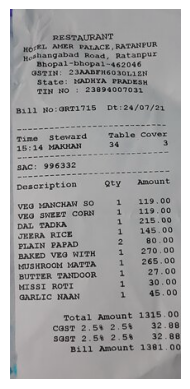


Fields extracted successfully!
{
    "Supplier": {
        "Name": "HOTEL AMER PALACE",
        "Address": "Hoshangabad Road, Ratanpur, Bhopal-462046, Madhya Pradesh",
        "GST Number": "23AABFH6030L1ZN",
        "TIN Number": "23894007031",
        "Contact": null
    },
    "ReceiptDetails": {
        "Billing Address": null,
        "Shipping Address": null,
        "Invoice Number": "GRT1715",
        "Date": "2021-07-24",
        "Time": "15:14"
    },
    "Items": [
        {
            "ItemName": "VEG MANCHAW SO",
            "Quantity": 1,
            "Unit Price": "119.00",
            "Total Price": "119.00"
        },
        {
            "ItemName": "VEG SWEET CORN",
            "Quantity": 1,
            "Unit Price": "119.00",
            "Total Price": "119.00"
        },
        {
            "ItemName": "DAL TADKA",
            "Quantity": 1,
            "Unit Price": "215.00",
            "Total Price": "215.00"
        },
        {
            "ItemName": "JE

In [7]:
if __name__ == "__main__":
    main()